## Potential future analysis

- we used scGPT_human checkpoint from zero shot tutorial, we could explore different model checkpoints
- with less computational constraints we could analyze
    - influence of methylation and mutation input data in combination with foundation model embeddings 
    - longer training cycles (epoch=500 in scFoundation eval)
    - 

In [87]:

import pandas as pd
from scipy.stats import pearsonr,spearmanr
import numpy as np
import os
import matplotlib.pyplot as plt


In [114]:
def extract_model_name(filename):
    """
    Extrahieren von Modellinformationen aus einem Dateinamen und Erstellung eines kurzen,
    für Tabellen geeigneten Strings.
    
    Args:
        filename (str): Der Dateiname des Modells.
    
    Returns:
        str: Ein kurzer, prägnanter String.
    """
    
    # Input-Daten (Cell Representation)
    input_data = ""
    if "with_mut" in filename and "with_gexp" in filename and "with_methy" in filename:
        input_data = "Multi-Omics"
    elif "with_gexp" in filename:
        input_data = "Transcr."
    
    if input_data == "":
        if "transcr" in filename:
            input_data = "Transcr."
        elif "multi-omics" in filename or "multiomics" in filename:
            input_data = "Multi-Omics"
    # Drug Encoder
    drug_encoder = ""
    if "256_256_256" in filename:
        drug_encoder = "GCN"
    elif "molformer" in filename:
        drug_encoder = "Molformer"
    
    # Cell Encoder
    cell_encoder = ""
    if "scGPT_embeddings" in filename:
        cell_encoder = "scGPT"
    elif "scFound_embeddings" in filename:
        cell_encoder = "scFoundation"
    else:
        cell_encoder = "Subnets"
    
    # Kombinieren der Informationen
    return f"{input_data}, {drug_encoder}, {cell_encoder}"

## Average PCC scores

In [89]:
def print_mean_results(name, pccs, rmse):
    """
    Prints mean results in a formatted table row with labels.
    """
    mean_pcc = np.mean(pccs)
    std_pcc = np.std(pccs)
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    num_values = len(pccs)

    # The new f-string uses a consistent structure for each data point:
    # {label_text:<width} {value:>width.precision}
    # This ensures that all labels and values are perfectly aligned.
    print(f"{name:<50} | PCC: {mean_pcc:>10.3f}  ±{std_pcc:<10.3f} | RMSE: {mean_rmse:>10.3f}  ±{std_rmse:<10.3f} | #: {num_values:>5d}")

def get_pccs(path, filter):
    files = [file for file in os.listdir(path) if filter in file and (file.endswith(".npz") and not file.endswith("4.npz"))]
    assert len(files) == 3, f"Expected 3 files, found {len(files)} for filter {filter}: {files}"
    pccs, sccs, rmses = [], [], []

    for file in files:
        data = np.load(os.path.join(path, file))
        pccs.append(pearsonr(data["pred"], data["test"])[0])
        sccs.append(spearmanr(data["pred"], data["test"])[0])
        rmses.append(np.sqrt(np.mean((data["pred"] - data["test"]) ** 2)))

    #print(f"Model: {filter}")
    #print(f"Avg PCC: {np.mean(pccs):.3f} ± {np.std(pccs):.3f}")
    #print(f"Avg SCC: {np.mean(sccs):.3f} ± {np.std(sccs):.3f}")
    #print(f"Avg RMSE: {np.mean(rmses):.3f} ± {np.std(rmses):.3f}")
    
    print_mean_results(extract_model_name(filter), pccs, rmses)
    #print(30*"=")
    return pccs


def evaluate_models(drug_model="256_256_256_bn_relu_GAP"):
    path = "../data/eval/pcc/"
    results = {}

    configs = [
        ("scGPT (all omics)", f"DeepCDR_with_mut_with_gexp_with_methy_{drug_model}_scGPT_embeddings_run"),
        ("scF (all omics)", f"DeepCDR_with_mut_with_gexp_with_methy_{drug_model}_scFound_embeddings_run"),
        ("Base (all omics)", f"DeepCDR_with_mut_with_gexp_with_methy_{drug_model}_run"),
        ("scGPT (sparse)", f"DeepCDR_without_mut_with_gexp_without_methy_{drug_model}_scGPT_embeddings_run"),
        ("scF (sparse)", f"DeepCDR_without_mut_with_gexp_without_methy_{drug_model}_scFound_embeddings_run"),
        ("Base (sparse)", f"DeepCDR_without_mut_with_gexp_without_methy_{drug_model}_run"),
    ]

    for name, filter in configs:
        results[name] = get_pccs(path, filter)

    return results

def evaluate_models_by_type(model_types=("scGPT", "Base", "scF")):
    """
    Evaluate all drug model variants (e.g., dense + transformer) for selected model types.
    `model_types`: list or tuple of 'scGPT', 'scF', 'Base'
    """
    path = "../data/eval/pcc/"
    results = {}

    drug_models = ["256_256_256_bn_relu_GAP", "molformer", "chemberta"]
    
    for drug_model in drug_models:
        for model_type in model_types:
            if model_type == "scGPT":
                sparse_name = f"scGPT (sparse, {drug_model})"
                all_name = f"scGPT (all omics, {drug_model})"
                sparse_filter = f"DeepCDR_without_mut_with_gexp_without_methy_{drug_model}_scGPT_embeddings_run"
                all_filter = f"DeepCDR_with_mut_with_gexp_with_methy_{drug_model}_scGPT_embeddings_run"
            elif model_type == "scF":
                sparse_name = f"scF (sparse, {drug_model})"
                all_name = f"scF (all omics, {drug_model})"
                sparse_filter = f"DeepCDR_without_mut_with_gexp_without_methy_{drug_model}_scFound_embeddings_run"
                all_filter = f"DeepCDR_with_mut_with_gexp_with_methy_{drug_model}_scFound_embeddings_run"
            elif model_type == "Base":
                sparse_name = f"Base (sparse, {drug_model})"
                all_name = f"Base (all omics, {drug_model})"
                sparse_filter = f"DeepCDR_without_mut_with_gexp_without_methy_{drug_model}_run"
                all_filter = f"DeepCDR_with_mut_with_gexp_with_methy_{drug_model}_run"
            else:
                raise ValueError(f"Unsupported model_type: {model_type}")

            results[all_name] = get_pccs(path, all_filter)
            results[sparse_name] = get_pccs(path, sparse_filter)

    return results

def barplot_avgs(results, drugmodelname="base"):
    import numpy as np
    import matplotlib.pyplot as plt
    from collections import defaultdict

    full_labels = list(results.keys())
    means = [np.mean(results[k]) for k in full_labels]
    stds = [np.std(results[k]) for k in full_labels]

    # Extract drug model and short label separately
    def parse_label(label):
        # e.g. "scGPT (all omics, 256_256_256_bn_relu_GAP)"
        if ',' in label:
            parts = label.split(',')
            model_part = parts[0].strip()  # e.g. "scGPT (all omics"
            drug_model_part = parts[1].strip(' )')
            return model_part, drug_model_part
        else:
            return label, ""

    parsed = [parse_label(l) for l in full_labels]
    short_labels = [p[0] + ')' if not p[0].endswith(')') else p[0] for p in parsed]  # close paren if missing
    drug_models = [p[1] for p in parsed]

    def get_color(label):
        if 'scGPT' in label:
            return 'seagreen' if 'all' in label else 'lightgreen'
        elif 'scF' in label:
            return 'goldenrod' if 'all' in label else 'khaki'
        elif 'Base' in label:
            return 'steelblue' if 'all' in label else 'skyblue'
        else:
            return 'grey'

    colors = [get_color(label) for label in short_labels]

    fig, ax = plt.subplots(figsize=(12, 6))

    bars = ax.bar(range(len(short_labels)), means, yerr=stds, capsize=5,
                  color=colors, edgecolor='black')

    # Add mean value text on top of bars
    for bar, mean in zip(bars, means):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f'{mean:.3f}',
                ha='center', va='bottom', fontsize=8)

    # Find indices where drug model changes
    sep_indices = [i for i in range(1, len(drug_models)) if drug_models[i] != drug_models[i-1]]

    # Add vertical separators
    for idx in sep_indices:
        ax.axvline(idx - 0.5, color='grey', linestyle='--', linewidth=1)

    # Add drug model section labels above plot
    groups = defaultdict(list)
    for i, dm in enumerate(drug_models):
        name = dm.split(' ')[0] 
        if name == "256_256_256_bn_relu_GAP":
            name = "Base GCN"
        elif name == "molformer":
            name = "MolFormer"
        elif name == "chemberta":
            name = "ChemBERTa"
        
        groups[name].append(i)

    ylim = ax.get_ylim()
    y_pos = ylim[1] + 0.05 * (ylim[1] - ylim[0])

    # Place drug model labels below the x-axis, centered under their groups
    for dm, indices in groups.items():
        start = min(indices)
        end = max(indices)
        center = (start + end) / 2
        ax.text(center, ylim[0] - 0.35*(ylim[1]-ylim[0]), dm, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())


    ax.set_xticks(range(len(short_labels)))
    ax.set_xticklabels(short_labels, rotation=45, ha='right')
    ax.set_ylabel('Mean PCC')
    ax.set_title('Overall Model Comparison (mean PCC with std) - ' + drugmodelname)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # leave space on top for text
    plt.show()



    
def boxplot_avgs(results, drugmodelname="base"):
    import numpy as np
    import matplotlib.pyplot as plt

    full_labels = list(results.keys())
    data = [results[k] for k in full_labels]

    # Extract drug model and short label separately
    def parse_label(label):
        # example full label: "scGPT (all omics, 256_256_256_bn_relu_GAP)"
        if ',' in label:
            parts = label.split(',')
            model_part = parts[0].strip()  # e.g. "scGPT (all omics"
            drug_model_part = parts[1].strip(' )')
            return model_part, drug_model_part
        else:
            return label, ""

    parsed = [parse_label(l) for l in full_labels]
    short_labels = [p[0] + ')' if not p[0].endswith(')') else p[0] for p in parsed]  # close paren if missing
    drug_models = [p[1] for p in parsed]

    def get_color(label):
        if 'scGPT' in label:
            return 'seagreen' if 'all' in label else 'lightgreen'
        elif 'scF' in label:
            return 'goldenrod' if 'all' in label else 'khaki'
        elif 'Base' in label:
            return 'steelblue' if 'all' in label else 'skyblue'
        else:
            return 'grey'

    colors = [get_color(label) for label in short_labels]

    fig, ax = plt.subplots(figsize=(12, 6))
    box = ax.boxplot(data, patch_artist=True, labels=short_labels,
                     medianprops=dict(color='black'),
                     whiskerprops=dict(color='black'),
                     capprops=dict(color='black'),
                     flierprops=dict(marker='o', markersize=4, markerfacecolor='red'))

    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Find indices where drug model changes
    sep_indices = []
    for i in range(1, len(drug_models)):
        if drug_models[i] != drug_models[i-1]:
            sep_indices.append(i)

    # Add vertical separators & annotations for drug models
    for idx in sep_indices:
        ax.axvline(idx + 0.5, color='grey', linestyle='--', linewidth=1)

    # Add drug model section labels above plot
    # Collect ranges for each drug model group
    from collections import defaultdict
    groups = defaultdict(list)
    for i, dm in enumerate(drug_models):
        name = dm.split(' ')[0] 
        if name == "256_256_256_bn_relu_GAP":
            name = "Base GCN"
        elif name == "molformer":
            name = "MolFormer"
        elif name == "chemberta":
            name = "ChemBERTa"
        
        groups[name].append(i)

    ylim = ax.get_ylim()
    y_pos = ylim[1] + 0.05 * (ylim[1] - ylim[0])

    for dm, indices in groups.items():
        start = min(indices)
        end = max(indices)
        center = (start + end) / 2

        # Convert data coordinate to figure coordinate
        x_fig = (center + 1) / (len(short_labels) + 1)  # +1 due to 1-based xtick positions
        fig.text(x_fig, -0.01, dm, ha='center', va='bottom', fontsize=11, fontweight='bold')
        
    ax.set_ylabel('PCC')
    ax.set_title('Overall Model Comparison (PCC per run) - ' + drugmodelname)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # leave space on top for text
    plt.show()



In [90]:
results = evaluate_models()
results

Multi-Omics, GCN, scGPT                            | PCC:      0.920  ±0.000      | RMSE:      1.076  ±0.004      | #:     3
Multi-Omics, GCN, scFoundation                     | PCC:      0.920  ±0.003      | RMSE:      1.076  ±0.019      | #:     3
Multi-Omics, GCN, Subnets                          | PCC:      0.920  ±0.002      | RMSE:      1.076  ±0.007      | #:     3
Transcr., GCN, scGPT                               | PCC:      0.914  ±0.003      | RMSE:      1.115  ±0.015      | #:     3
Transcr., GCN, scFoundation                        | PCC:      0.882  ±0.005      | RMSE:      1.299  ±0.027      | #:     3
Transcr., GCN, Subnets                             | PCC:      0.841  ±0.003      | RMSE:      1.483  ±0.009      | #:     3


{'scGPT (all omics)': [0.9202202242593508,
  0.9199975504687574,
  0.9202044270581821],
 'scF (all omics)': [0.9162921472738483,
  0.9186529932918712,
  0.924589147983515],
 'Base (all omics)': [0.9193051296468624,
  0.9183695912469376,
  0.9223585661274464],
 'scGPT (sparse)': [0.9151664760651226,
  0.9102385819476709,
  0.9158593134181126],
 'scF (sparse)': [0.8807847553040306, 0.877514061112564, 0.8883253669184064],
 'Base (sparse)': [0.8397442335015423, 0.8373899189317658, 0.8453888182994858]}

# Standard Drug Model

Multi-Omics, GCN, scGPT                            | PCC:      0.920  ±0.000      | RMSE:      1.076  ±0.004      | #:     3
Multi-Omics, GCN, scFoundation                     | PCC:      0.920  ±0.003      | RMSE:      1.076  ±0.019      | #:     3
Multi-Omics, GCN, Subnets                          | PCC:      0.920  ±0.002      | RMSE:      1.076  ±0.007      | #:     3
Transcr., GCN, scGPT                               | PCC:      0.914  ±0.003      | RMSE:      1.115  ±0.015      | #:     3
Transcr., GCN, scFoundation                        | PCC:      0.882  ±0.005      | RMSE:      1.299  ±0.027      | #:     3
Transcr., GCN, Subnets                             | PCC:      0.841  ±0.003      | RMSE:      1.483  ±0.009      | #:     3


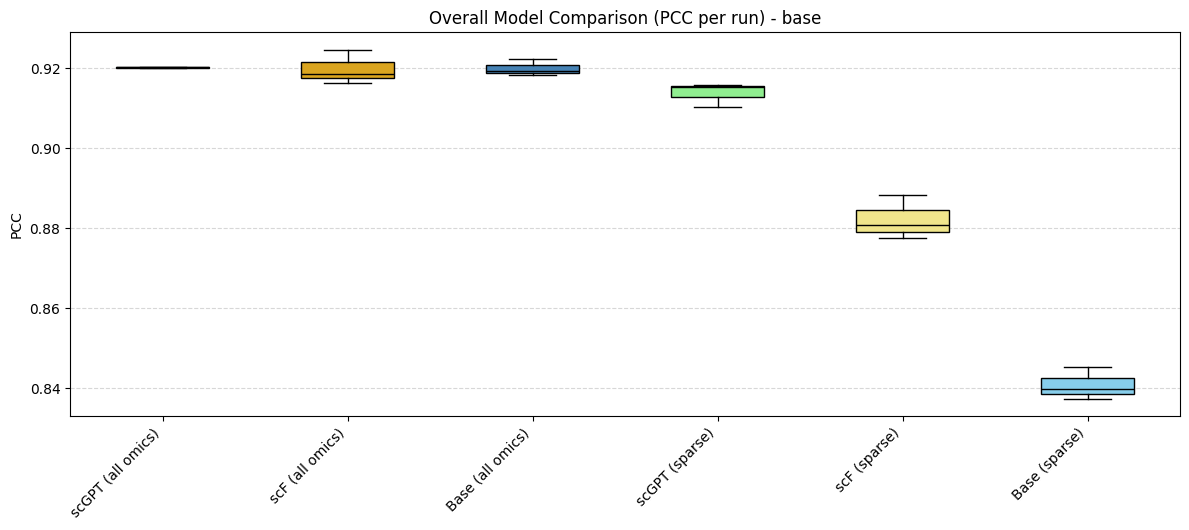

In [91]:
results = evaluate_models()


    
boxplot_avgs(results, drugmodelname="base")



Multi-Omics, GCN, scGPT                            | PCC:      0.920  ±0.000      | RMSE:      1.076  ±0.004      | #:     3
Multi-Omics, GCN, scFoundation                     | PCC:      0.920  ±0.003      | RMSE:      1.076  ±0.019      | #:     3
Multi-Omics, GCN, Subnets                          | PCC:      0.920  ±0.002      | RMSE:      1.076  ±0.007      | #:     3
Transcr., GCN, scGPT                               | PCC:      0.914  ±0.003      | RMSE:      1.115  ±0.015      | #:     3
Transcr., GCN, scFoundation                        | PCC:      0.882  ±0.005      | RMSE:      1.299  ±0.027      | #:     3
Transcr., GCN, Subnets                             | PCC:      0.841  ±0.003      | RMSE:      1.483  ±0.009      | #:     3


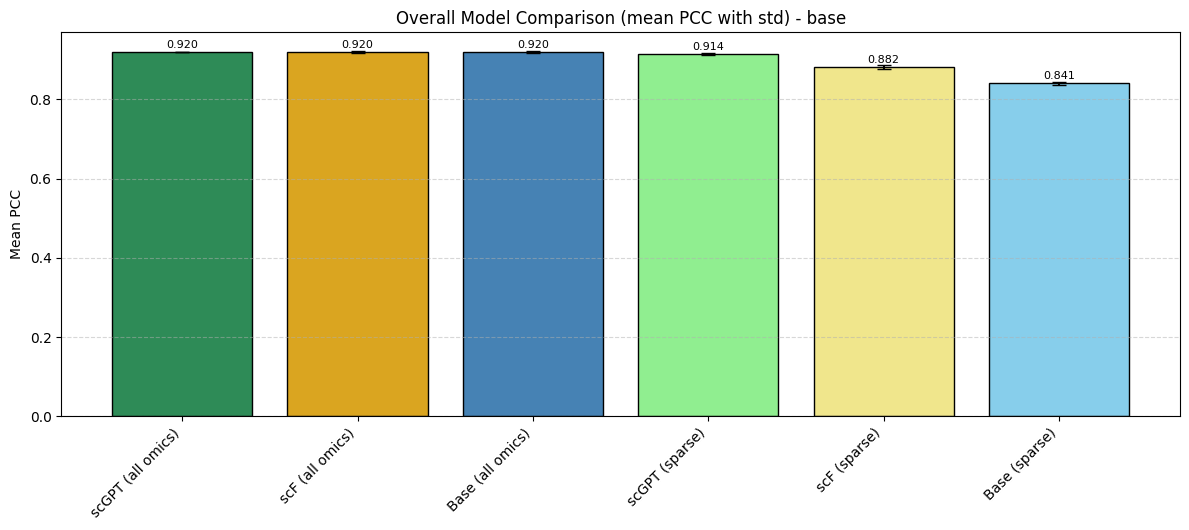

In [92]:
results = evaluate_models()
barplot_avgs (results, drugmodelname="base")

# Molformer

Multi-Omics, Molformer, scGPT                      | PCC:      0.919  ±0.003      | RMSE:      1.084  ±0.018      | #:     3
Multi-Omics, Molformer, scFoundation               | PCC:      0.919  ±0.002      | RMSE:      1.089  ±0.012      | #:     3
Multi-Omics, Molformer, Subnets                    | PCC:      0.919  ±0.002      | RMSE:      1.081  ±0.011      | #:     3
Transcr., Molformer, scGPT                         | PCC:      0.912  ±0.002      | RMSE:      1.125  ±0.013      | #:     3
Transcr., Molformer, scFoundation                  | PCC:      0.884  ±0.003      | RMSE:      1.308  ±0.004      | #:     3
Transcr., Molformer, Subnets                       | PCC:      0.848  ±0.009      | RMSE:      1.454  ±0.037      | #:     3


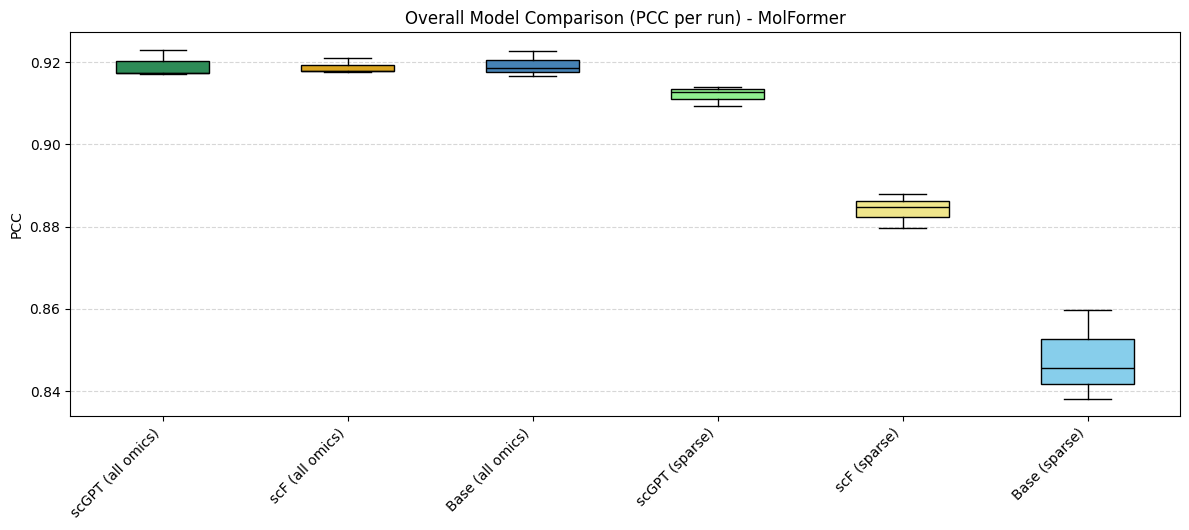

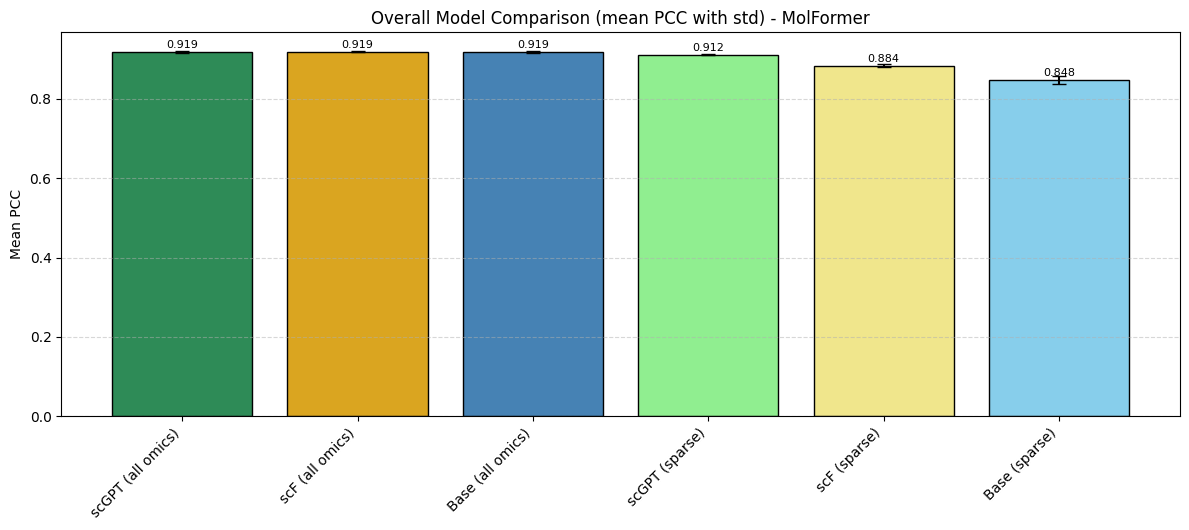

In [93]:
results = evaluate_models("molformer")

boxplot_avgs(results, drugmodelname="MolFormer")
barplot_avgs(results, drugmodelname="MolFormer")

# chemberta

Multi-Omics, , scGPT                               | PCC:      0.881  ±0.006      | RMSE:      1.332  ±0.037      | #:     3
Multi-Omics, , scFoundation                        | PCC:      0.877  ±0.008      | RMSE:      1.322  ±0.027      | #:     3
Multi-Omics, , Subnets                             | PCC:      0.878  ±0.003      | RMSE:      1.326  ±0.015      | #:     3
Transcr., , scGPT                                  | PCC:      0.876  ±0.008      | RMSE:      1.321  ±0.034      | #:     3
Transcr., , scFoundation                           | PCC:      0.858  ±0.006      | RMSE:      1.440  ±0.017      | #:     3
Transcr., , Subnets                                | PCC:      0.821  ±0.002      | RMSE:      1.598  ±0.032      | #:     3


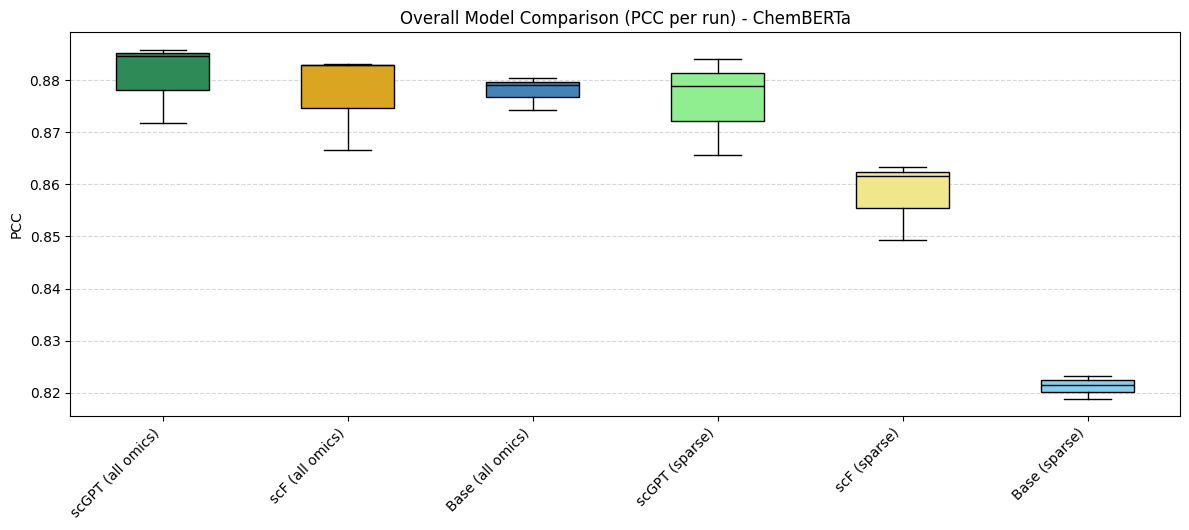

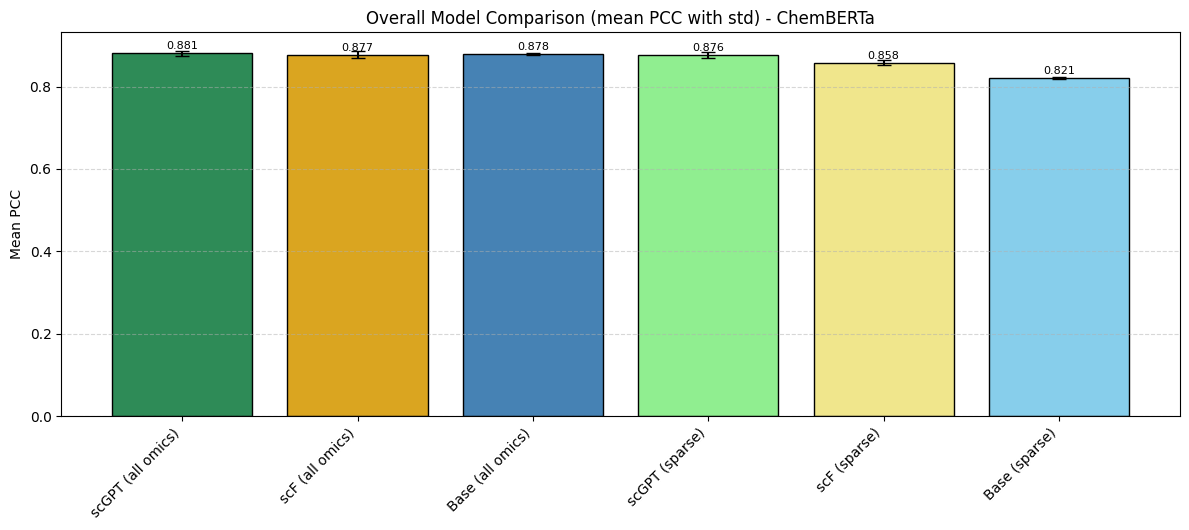

In [94]:
results = evaluate_models("chemberta")

boxplot_avgs(results, drugmodelname="ChemBERTa")
barplot_avgs(results, drugmodelname="ChemBERTa")

In [119]:
def evaluate_fusion_models_by_type(model_types=("scGPT", "scFound")):
    """
    Evaluate all drug model variants (e.g., dense + transformer) for selected model types.
    `model_types`: list or tuple of 'scGPT', 'scF', 'Base'
    """
    path = "../data/eval/pcc_fusion/"
    results = {}

    drug_models = ["molformer"]
    print("------FUSION-------")
    for arch_type in ["cdr", "mlp", "single"]:
        print(f"--- Architecture: {arch_type} ---")
        for drug_model in drug_models:
            for model_type in model_types:
                if model_type == "scGPT" or model_type == "scFound":
                    sparse_name = f"Fusion - {arch_type}, {model_type} (sparse, {drug_model})"
                    all_name = f"Fusion - {arch_type}, {model_type} (all omics, {drug_model})"
                    sparse_filter = f"DeepCDR_fusion_{arch_type}_{drug_model}_{model_type}_embeddings_transcriptomics_run"
                    all_filter = f"DeepCDR_fusion_{arch_type}_{drug_model}_{model_type}_embeddings_multi-omics_run"
                else:
                    raise ValueError(f"Unsupported model_type: {model_type}")
                results[sparse_name] = get_pccs(path, sparse_filter)
                results[all_name] = get_pccs(path, all_filter)

    return results

------FUSION-------
--- Architecture: cdr ---
Transcr., Molformer, scGPT                         | PCC:      0.932  ±0.001      | RMSE:      0.990  ±0.007      | #:     3
Multi-Omics, Molformer, scGPT                      | PCC:      0.932  ±0.000      | RMSE:      0.993  ±0.006      | #:     3
Transcr., Molformer, scFoundation                  | PCC:      0.932  ±0.000      | RMSE:      0.997  ±0.004      | #:     3
Multi-Omics, Molformer, scFoundation               | PCC:      0.932  ±0.001      | RMSE:      0.992  ±0.006      | #:     3
--- Architecture: mlp ---
Transcr., Molformer, scGPT                         | PCC:      0.932  ±0.001      | RMSE:      0.989  ±0.003      | #:     3
Multi-Omics, Molformer, scGPT                      | PCC:      0.932  ±0.001      | RMSE:      0.995  ±0.003      | #:     3
Transcr., Molformer, scFoundation                  | PCC:      0.932  ±0.001      | RMSE:      0.991  ±0.003      | #:     3
Multi-Omics, Molformer, scFoundation               | 

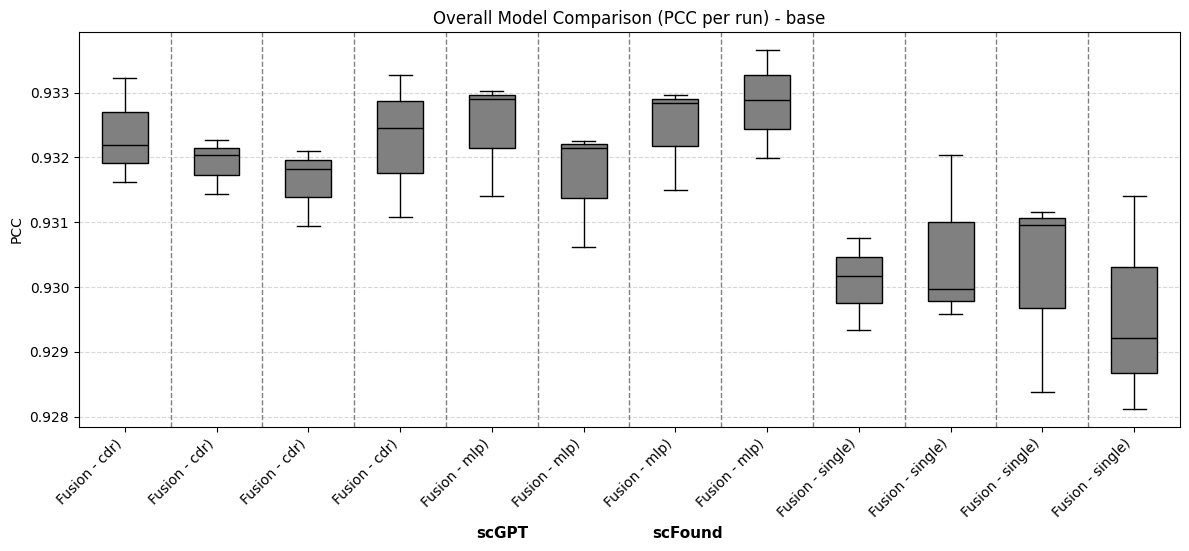

In [120]:
results = evaluate_fusion_models_by_type()

boxplot_avgs(results)

# Big combined plot

Multi-Omics, GCN, scGPT                            | PCC:      0.920  ±0.000      | RMSE:      1.076  ±0.004      | #:     3
Transcr., GCN, scGPT                               | PCC:      0.914  ±0.003      | RMSE:      1.115  ±0.015      | #:     3
Multi-Omics, GCN, Subnets                          | PCC:      0.920  ±0.002      | RMSE:      1.076  ±0.007      | #:     3
Transcr., GCN, Subnets                             | PCC:      0.841  ±0.003      | RMSE:      1.483  ±0.009      | #:     3
Multi-Omics, GCN, scFoundation                     | PCC:      0.920  ±0.003      | RMSE:      1.076  ±0.019      | #:     3
Transcr., GCN, scFoundation                        | PCC:      0.882  ±0.005      | RMSE:      1.299  ±0.027      | #:     3
Multi-Omics, Molformer, scGPT                      | PCC:      0.919  ±0.003      | RMSE:      1.084  ±0.018      | #:     3
Transcr., Molformer, scGPT                         | PCC:      0.912  ±0.002      | RMSE:      1.125  ±0.013      | #:     3


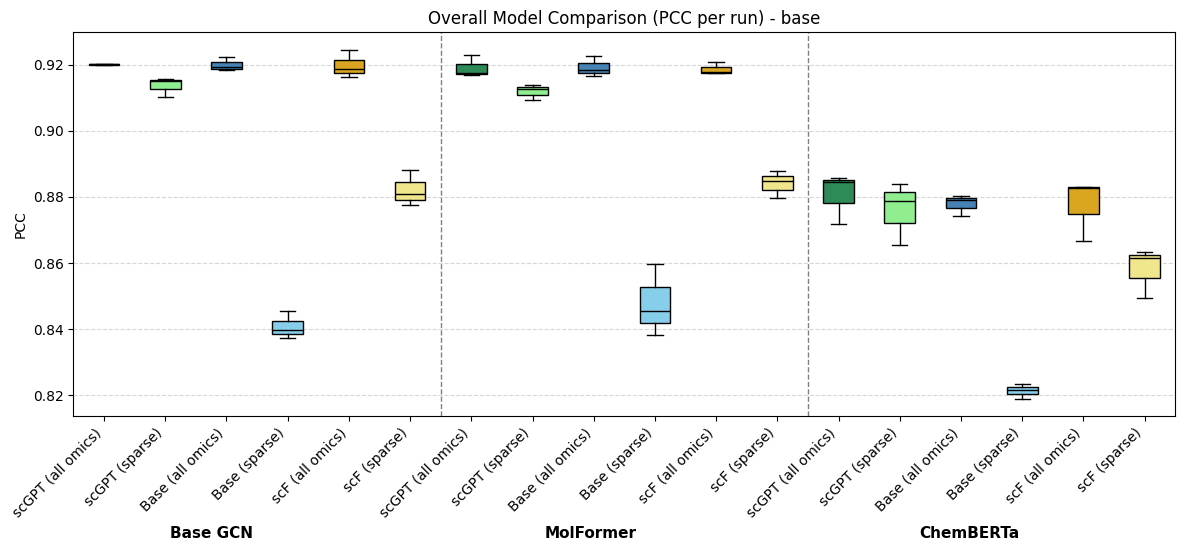

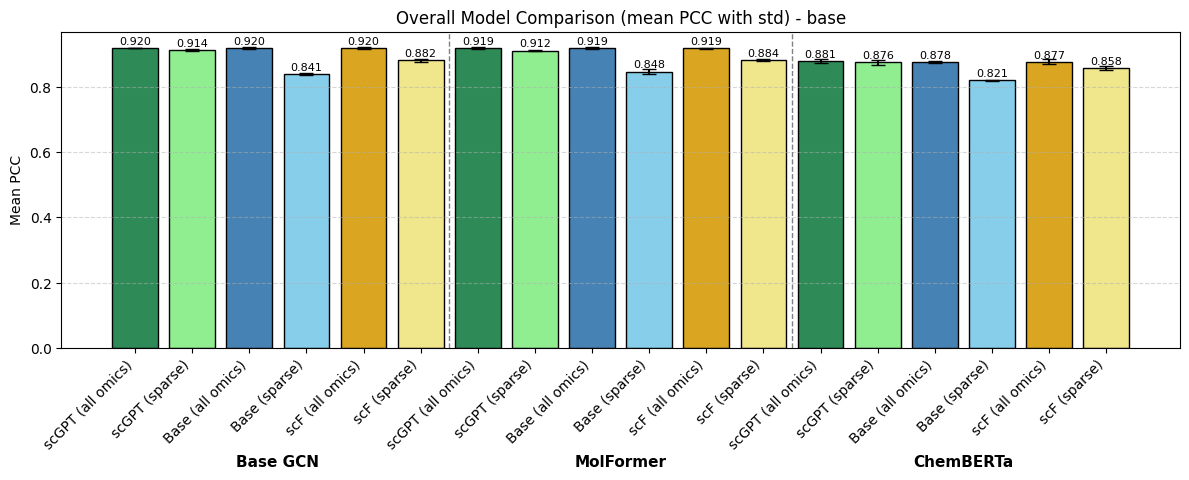

In [95]:
results = evaluate_models_by_type()

boxplot_avgs(results)
barplot_avgs(results)

## Compare results with results from original papers
results from original DeepCDR paper match with our value

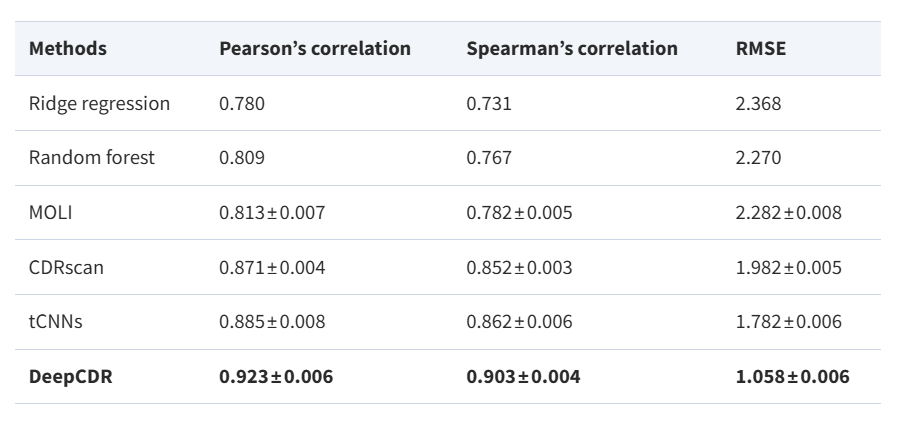

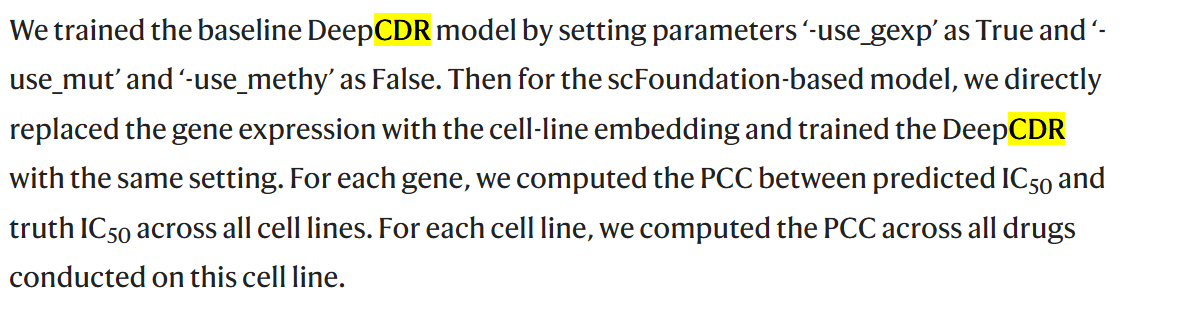

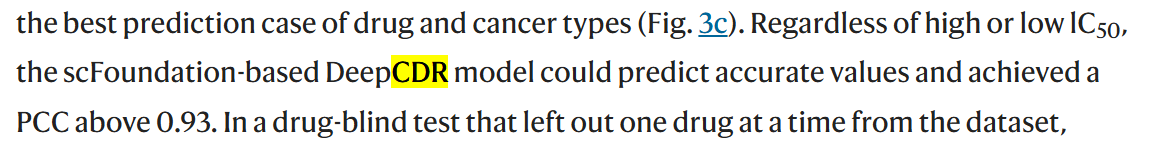

deepcdr reuslts doesnt match ( they claim above **0.93** pcc, but we got **0.89** (Avg PCC: 0.886 ± 0.006)) -> averaged results over 3 runs, standart deviation was pretty low -> difference probably not caused by randomness

**Possible reasons:**
- doublechecked: no use of mutation and methylation data -> no reason
- one difference was, that we train for less epochs (60 instead of 500)
    - tested -> no improvement (PCC: **0.88**) -> no reason
- used embeddings generated by original scFound repository -> no reason
- adapted model to new tensorflow version -> check if some changes happened



## Adaptation
### 1. Adapt Network architecture
current Architecture:
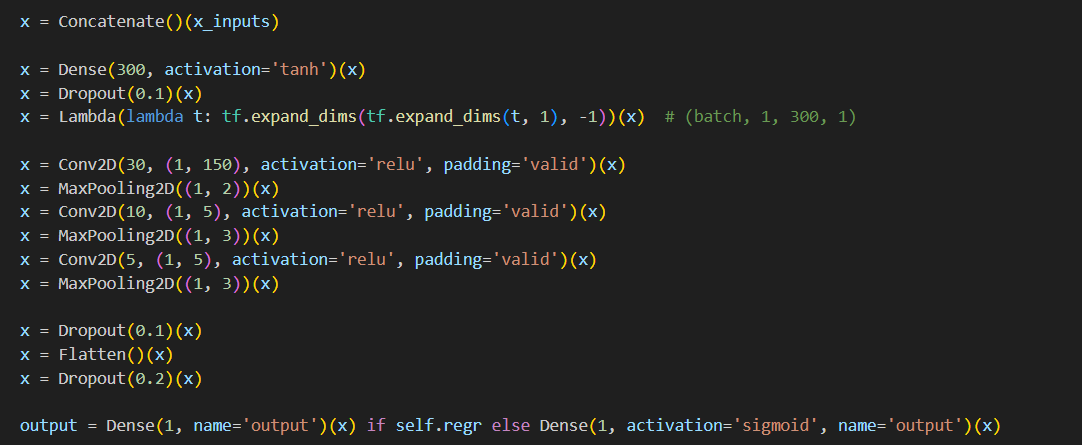
- rational: mutation and methylation data doesnt improve performance for scGPT model -> change architecture for combining 
- why use of Convolutions -> maybe just straight FNNs work better
    - Convs are for shared weights with to extract features indepentent of its position
    - i dont see that this is given in our case

### 2. Adapt drug embedding architecture 
- rational: use fm model for gene expressions improve model performance -> same could work for drugs
- currently in prgress:
    - created embeddings for chemberta 
        - (also tested Molformer works same way, but only smaller pretrained model available)
    - adapt code

## Leave one drug out PCC scores

In [96]:
import math
import os


from scipy.linalg import norm
import numpy as np

def rmse(pred, true):
    pred = np.array(pred)
    true = np.array(true)
    return norm(pred - true) / np.sqrt(len(pred))


def get_avg_pcc(path):
    files = os.listdir(path)
    drugnames = [file.split('.')[0] for file in files if file.endswith('.npz')]
    pccs = []
    rmses = []
    for file in files:
        if file.endswith('.npz'): #and file.split('.')[0] in trained_leavedrug:
            data = np.load(os.path.join(path, file))
            y_true = data['test']
            y_pred = data['pred']
            pcc, _ = pearsonr(y_true, y_pred)
            rmse_value = rmse(y_pred, y_true)
            if math.isnan(pcc):
                pcc = 0.0
            pccs.append(pcc)
            rmses.append(rmse_value)

    return pccs, rmses


def get_drug_pccs_with_names(path):
    files = os.listdir(path)
    drugnames = [file.split('.')[0] for file in files if file.endswith('.npz')]
    pccs = []
    rmses = []
    for file in files:
        if file.endswith('.npz'): #and file.split('.')[0] in trained_leavedrug:
            data = np.load(os.path.join(path, file))
            y_true = data['test']
            y_pred = data['pred']
            pcc, _ = pearsonr(y_true, y_pred)
            rmse_value = rmse(y_pred, y_true)
            if math.isnan(pcc):
                pcc = 0.0
            pccs.append(pcc)
            rmses.append(rmse_value)
    
    
    df = pd.DataFrame({
        "Drug": drugnames,
        "PCC": pccs,
        "RMSE": rmses
    })
    
    return df

In [109]:
directory = "../data/eval/leave_drug_opt"
scGPT_dir = "without_mut_with_gexp_without_methy_256_256_256_bn_relu_GAP_scGPT_embeddings_run_1"
scGPT_with_dir = "with_mut_with_gexp_with_methy_256_256_256_bn_relu_GAP_scGPT_embeddings_run_1"
scFound_dir = "without_mut_with_gexp_without_methy_256_256_256_bn_relu_GAP_scFound_embeddings_run_1"
base_dir = "without_mut_with_gexp_without_methy_256_256_256_bn_relu_GAP_run_1"
base_with_omics_dir = "with_mut_with_gexp_with_methy_256_256_256_bn_relu_GAP_run_1"
scFound_with_dir = "with_mut_with_gexp_with_methy_256_256_256_bn_relu_GAP_scFound_embeddings_run_1"

# drug model
scGPT_molformer_dir = "without_mut_with_gexp_without_methy_molformer_scGPT_embeddings_run_1"
scGPT_molformer_with_dir = "with_mut_with_gexp_with_methy_molformer_scGPT_embeddings_run_1"
scFound_molformer_dir = "without_mut_with_gexp_without_methy_molformer_scFound_embeddings_run_1"
base_molformer_dir = "without_mut_with_gexp_without_methy_molformer_run_1"
base_molformer_with_dir = "with_mut_with_gexp_with_methy_molformer_run_1"
scFound_molformer_with_dir = "with_mut_with_gexp_with_methy_molformer_scFound_embeddings_run_1"

#fusion model
fusion_dir = "../data/eval/leave_drug_fusion"
fusion_molformer_scgpt_multiomics_dir = "fusion_fusion_molformer_scGPT_embeddings_multi-omics_run_1"
fusion_molformer_scgpt_trans_dir = "fusion_fusion_molformer_scGPT_embeddings_transcriptomics_run_1"
fusion_molformer_scFound_multiomics_dir = "fusion_fusion_molformer_scFound_embeddings_multi-omics_run_1"
fusion_molformer_scFound_trans_dir = "fusion_fusion_molformer_scFound_embeddings_transcriptomics_run_1"
#mlp
fusion_mlp_molformer_scgpt_multiomics_dir = "fusion_mlp_molformer_scGPT_embeddings_multi-omics_run_1"
fusion_mlp_molformer_scgpt_trans_dir = "fusion_mlp_molformer_scGPT_embeddings_transcriptomics_run_1"
fusion_mlp_molformer_scFound_multiomics_dir = "fusion_mlp_molformer_scFound_embeddings_multi-omics_run_1"
fusion_mlp_molformer_scFound_trans_dir = "fusion_mlp_molformer_scFound_embeddings_transcriptomics_run_1"


In [98]:
drug_pccs_base = get_drug_pccs_with_names(os.path.join(directory, base_dir))
drug_pccs_scgpt = get_drug_pccs_with_names(os.path.join(directory, scGPT_dir))
drug_pccs_scFound = get_drug_pccs_with_names(os.path.join(directory, scFound_dir))
drug_pccs_base_with_omics = get_drug_pccs_with_names(os.path.join(directory, base_with_omics_dir))
drug_pccs_scgpt_with = get_drug_pccs_with_names(os.path.join(directory, scGPT_with_dir))
drug_pccs_scFound_with = get_drug_pccs_with_names(os.path.join(directory, scFound_with_dir))

drug_pccs_base_molformer = get_drug_pccs_with_names(os.path.join(directory, base_molformer_dir))
drug_pccs_scgpt_molformer = get_drug_pccs_with_names(os.path.join(directory, scGPT_molformer_dir))
drug_pccs_scFound_molformer = get_drug_pccs_with_names(os.path.join(directory, scFound_molformer_dir))
drug_pccs_base_molformer_with_omics = get_drug_pccs_with_names(os.path.join(directory, base_molformer_with_dir))
drug_pccs_scgpt_molformer_with = get_drug_pccs_with_names(os.path.join(directory, scGPT_molformer_with_dir))
drug_pccs_scFound_molformer_with = get_drug_pccs_with_names(os.path.join(directory, scFound_molformer_with_dir))

def join_dfs(df1, df2, name1, name2):
    """
    Joins two DataFrames on the 'Drug' column and returns the joined DataFrame.
    """
    joined_df = df1.merge(df2, on="Drug", suffixes=(f"_{name1}", f"_{name2}"))
    joined_df["PCC_diff"] = joined_df[f"PCC_{name2}"] - joined_df[f"PCC_{name1}"] 
    joined_df["RMSE_diff"] = joined_df[f"RMSE_{name2}"] - joined_df[f"RMSE_{name1}"] 
    joined_df.sort_values(by="PCC_diff", ascending=False, inplace=True)
    joined_df.reset_index(drop=True, inplace=True)
    return joined_df

pcc_diff_base = join_dfs(drug_pccs_base, drug_pccs_base_molformer, "base", "base_molformer")
pcc_diff_scgpt = join_dfs(drug_pccs_scgpt, drug_pccs_scgpt_molformer, "scGPT", "scGPT_molformer")
pcc_diff_scFound = join_dfs(drug_pccs_scFound, drug_pccs_scFound_molformer, "scFound", "scFound_molformer")
pcc_diff_base_with_omics = join_dfs(drug_pccs_base_with_omics, drug_pccs_base_molformer_with_omics, "base_with_omics", "base_molformer_with_omics")
pcc_diff_scgpt_with = join_dfs(drug_pccs_scgpt_with, drug_pccs_scgpt_molformer_with, "scGPT_with", "scGPT_molformer_with")
pcc_diff_scFound_with = join_dfs(drug_pccs_scFound_with, drug_pccs_scFound_molformer_with, "scFound_with", "scFound_molformer_with")

C:\Users\X390\AppData\Local\Temp\ipykernel_4384\3091319698.py:44: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc, _ = pearsonr(y_true, y_pred)


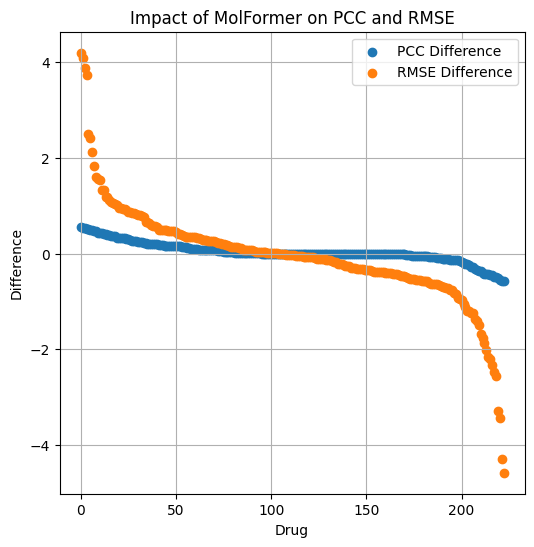

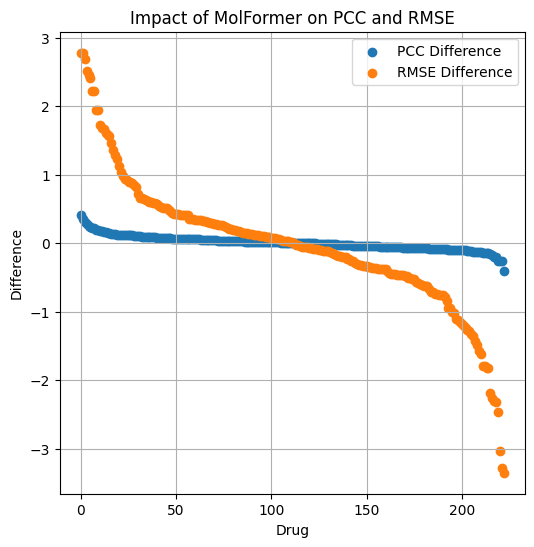

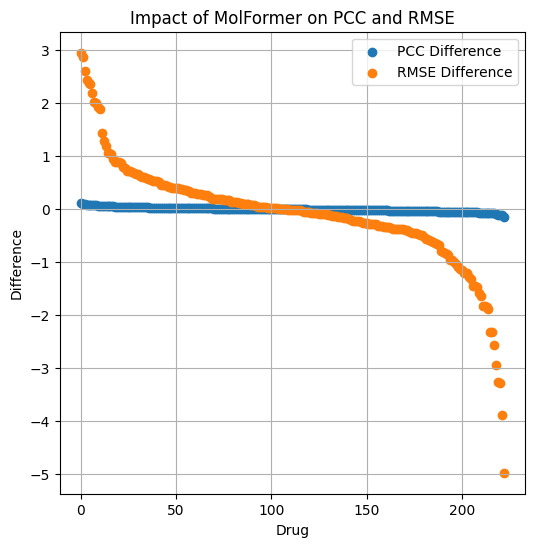

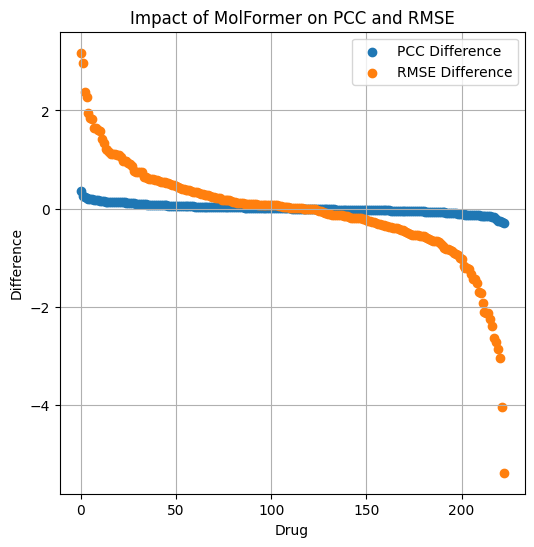

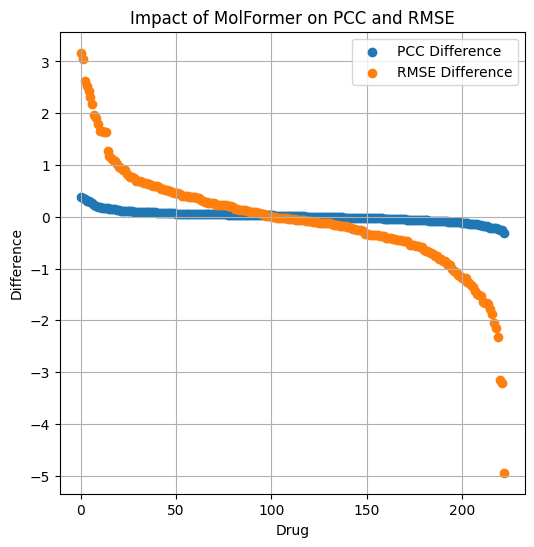

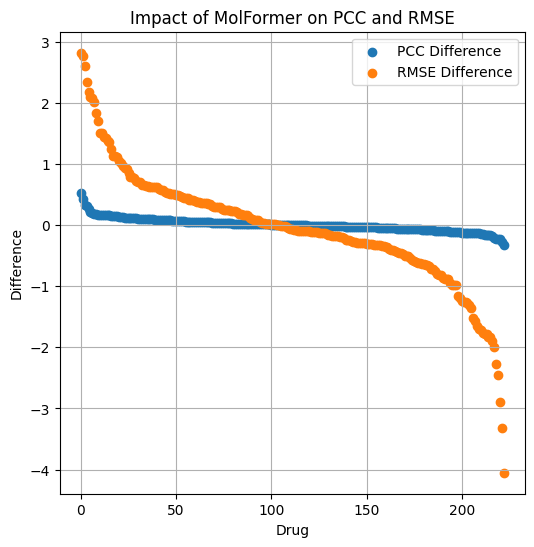

Name  Mean_PCC_diff  \
0                             Base vs Base MolFormer       0.031495   
1                           scGPT vs scGPT MolFormer       0.004695   
2                       scFound vs scFound MolFormer      -0.004365   
3       Base with Omics vs Base MolFormer with Omics       0.002648   
4     scGPT with Omics vs scGPT MolFormer with Omics       0.009129   
5  scFound with Omics vs scFound MolFormer with O...       0.003300   

   Std_PCC_diff  Max_PCC_diff  Min_PCC_diff  Mean_RMSE_diff  Std_RMSE_diff  \
0      0.208507      0.557714     -0.582227       -0.047402       1.073361   
1      0.103489      0.412057     -0.404322       -0.030801       0.980771   
2      0.039923      0.124937     -0.139185       -0.073406       1.004465   
3      0.092401      0.366413     -0.284226       -0.059934       1.006282   
4      0.105557      0.379463     -0.319312       -0.046901       0.979583   
5      0.107495      0.528864     -0.325995       -0.051885       0.959293   

   Max_RMSE_diff  Min_RMSE_diff  Number_positive_PCC_diff  ...  \
0       4.189191      -4.573612                        96  ...   
1       2.778780      -3.350733                       117  ...   
2       2.951986      -4.973521                       107  ...   
3       3.174738      -5.379847                       113  ...   
4       3.167702      -4.942905                       120  ...   
5       2.816962      -4.052038                       111  ...   

   Number_positive_RMSE_diff  Number_negative_RMSE_diff  \
0                        104                        119   
1                        112                        111   
2                        108                        115   
3                        118                        105   
4                        101                        122   
5                        104                        119   

   Number_zero_RMSE_diff                                           Top_10_1  \
0                      0  24894414,447912,53394750,53340664,16722836,991...   
1                      0  44182295,9826528,10074640,46943432,46931012,70...   
2                      0  46931012,10451420,5329102,24772860,46943432,98...   
3                      0  53340664,9826528,5291,10074640,44182295,691845...   
4                      0  44182295,9826528,5291,10074640,46931012,691845...   
5                      0  24951314,9826528,44182295,6918454,16747388,100...   

                                            Top_10_2  \
0  24894414,704473,16722836,11754511,6852167,1674...   
1  9826528,11754511,44182295,46931012,704473,5329...   
2  46931012,11754511,10451420,9810884,46885626,68...   
3  9826528,44182295,5329102,16747388,53340664,990...   
4  9826528,16747388,5291,11754511,24826799,461914...   
5  9826528,46191454,5329102,16747388,11754511,529...   

                                         Bottom_10_1  \
0  6505803,5460769,300471,11626560,10461815,44182...   
1  208908,300471,6505803,10184653,56965967,856687...   
2  10184653,208908,9826528,6505803,85668777,10127...   
3  85668777,10184653,6505803,208908,300471,249785...   
4  300471,85668777,208908,176870,10184653,6505803...   
5  6505803,300471,85668777,176870,208908,6852167,...   

                                         Bottom_10_2  meta_pcc top30_overlap  \
0  148124,9826528,44182295,208908,24785538,101846...  0.217948            12   
1  85668777,300471,10184653,208908,49806720,2375,...  0.717362            16   
2  6505803,208908,85668777,10184653,9826528,11707...  0.957253            24   
3  208908,300471,10184653,85668777,11640390,24978...  0.762151            19   
4  300471,10184653,24978538,85668777,176870,11640...  0.717494            20   
5  300471,10184653,208908,85668777,176870,1117823...  0.725061            15   

   bottom30_overlap  
0                19  
1                17  
2                26  
3                17  
4                17  
5                17  

[6 rows x 22 columns]

In [99]:
pcc_diff_scgpt

import matplotlib.pyplot as plt

def plot_diff(df):
    sorted_pcc = df.sort_values(by="PCC_diff", ascending=False)
    sorted_pcc.reset_index(drop=True, inplace=True)
    sorted_rmse = df.sort_values(by="RMSE_diff", ascending=False)
    sorted_rmse.reset_index(drop=True, inplace=True)
        
    plt.figure(figsize=(6, 6))
    plt.scatter(sorted_pcc.index,sorted_pcc["PCC_diff"])
    plt.scatter(sorted_rmse.index, sorted_rmse["RMSE_diff"])
    plt.xlabel("Drug")
    plt.ylabel("Difference")
    plt.title("Impact of MolFormer on PCC and RMSE")
    plt.grid(True)
    plt.legend(["PCC Difference", "RMSE Difference"])
    plt.show()
    
def evaluate_diff(df, setup_name, name1, name2):
    #for col_name in ["PCC_diff", "RMSE_diff"]:
    #    print(f"Mean {col_name}: {df[col_name].mean():.3f} ± {df[col_name].std():.3f}")
    #    print(f"Max {col_name}: {df[col_name].max():.3f} at index {df[col_name].idxmax()}")
    #    print(f"Min {col_name}: {df[col_name].min():.3f} at index {df[col_name].idxmin()}")
    #    print(f"Number of drugs with positive {col_name}: {(df[col_name] > 0).sum()} out of {len(df)}, negative: {(df[col_name] < 0).sum()}, zero: {(df[col_name] == 0).sum()}")
    #    print(f"Top 10 drugs increased with Molformer: \n{df.nlargest(10, col_name)[['Drug', col_name]]}")
    #    print(f"Bottom 10 drugs decreased with Molformer:\n {df.nsmallest(10, col_name)[['Drug', col_name]]}")
    plot_diff(df)
    return {"Name": setup_name,
            "Mean_PCC_diff": df["PCC_diff"].mean(),
            "Std_PCC_diff": df["PCC_diff"].std(),
            "Max_PCC_diff": df["PCC_diff"].max(),
            "Min_PCC_diff": df["PCC_diff"].min(),
            "Mean_RMSE_diff": df["RMSE_diff"].mean(),
            "Std_RMSE_diff": df["RMSE_diff"].std(),
            "Max_RMSE_diff": df["RMSE_diff"].max(),
            "Min_RMSE_diff": df["RMSE_diff"].min(),
            "Number_positive_PCC_diff": (df["PCC_diff"] > 0).sum(),
            "Number_negative_PCC_diff": (df["PCC_diff"] < 0).sum(),
            "Number_zero_PCC_diff": (df["PCC_diff"] == 0).sum(),
            "Number_positive_RMSE_diff": (df["RMSE_diff"] > 0).sum(),
            "Number_negative_RMSE_diff": (df["RMSE_diff"] < 0).sum(),
            "Number_zero_RMSE_diff": (df["RMSE_diff"] == 0).sum(),
            "Top_10_1": ",".join(df.nlargest(10, f"PCC_{name1}")["Drug"].tolist()),
            "Top_10_2": ",".join(df.nlargest(10, f"PCC_{name2}")["Drug"].tolist()),
            "Bottom_10_1": ",".join(df.nsmallest(10, f"PCC_{name1}")["Drug"].tolist()),
            "Bottom_10_2": ",".join(df.nsmallest(10, f"PCC_{name2}")["Drug"].tolist()),
            "meta_pcc": pearsonr(df[f"PCC_{name1}"], df[f"PCC_{name2}"])[0],
            "top30_overlap": len(set(df.nlargest(30, f"PCC_{name1}")["Drug"]).intersection(set(df.nlargest(30, f"PCC_{name2}")["Drug"]))),
            "bottom30_overlap": len(set(df.nsmallest(30, f"PCC_{name1}")["Drug"]).intersection(set(df.nsmallest(30, f"PCC_{name2}")["Drug"]))),
        }
        
    
def evaluate_all():
    results = []
    results.append(evaluate_diff(pcc_diff_base, "Base vs Base MolFormer", "base", "base_molformer"))
    results.append(evaluate_diff(pcc_diff_scgpt, "scGPT vs scGPT MolFormer", "scGPT", "scGPT_molformer"))
    results.append(evaluate_diff(pcc_diff_scFound, "scFound vs scFound MolFormer", "scFound", "scFound_molformer"))
    results.append(evaluate_diff(pcc_diff_base_with_omics, "Base with Omics vs Base MolFormer with Omics",  "base_with_omics", "base_molformer_with_omics"))
    results.append(evaluate_diff(pcc_diff_scgpt_with, "scGPT with Omics vs scGPT MolFormer with Omics", "scGPT_with", "scGPT_molformer_with"))
    results.append(evaluate_diff(pcc_diff_scFound_with, "scFound with Omics vs scFound MolFormer with Omics", "scFound_with", "scFound_molformer_with"))
    summary_df = pd.DataFrame(results)
    return summary_df
    
evaluate_all()
# compare top drug lists (rank by pcc)
# 


In [110]:
#fusion fusion
scF_transcriptomics_pccs, scF_rmse_trans = get_avg_pcc(f"{fusion_dir}/{fusion_molformer_scFound_trans_dir}")
scF_multiomics_pccs, scF_multiom_rmse = get_avg_pcc(f"{fusion_dir}/{fusion_molformer_scFound_multiomics_dir}")
scgpt_transcriptomics_pccs, scgpt_rmse_trans = get_avg_pcc(f"{fusion_dir}/{fusion_molformer_scgpt_trans_dir}")
scgpt_multiomics_pccs, scgpt_multiom_rmse = get_avg_pcc(f"{fusion_dir}/{fusion_molformer_scgpt_multiomics_dir}")
#fusion mlp
mlp_scF_transcriptomics_pccs, mlp_scF_rmse_trans = get_avg_pcc(f"{fusion_dir}/{fusion_mlp_molformer_scFound_trans_dir}")
mlp_scF_multiomics_pccs, mlp_scF_multiom_rmse = get_avg_pcc(f"{fusion_dir}/{fusion_mlp_molformer_scFound_multiomics_dir}")
mlp_scgpt_transcriptomics_pccs, mlp_scgpt_rmse_trans = get_avg_pcc(f"{fusion_dir}/{fusion_mlp_molformer_scgpt_trans_dir}")
mlp_scgpt_multiomics_pccs, mlp_scgpt_multiom_rmse = get_avg_pcc(f"{fusion_dir}/{fusion_mlp_molformer_scgpt_multiomics_dir}")

In [111]:

from collections import defaultdict
import numpy as np


def compute_pccs(base_path, scgpt_path, scFound_path, base_with_path, scgpt_with_path, scFound_with_path):
    pccs,rmse = get_avg_pcc(scgpt_path)
    pccs_scFound,rmse_scfound = get_avg_pcc(scFound_path)
    pccs_base,rmse_base = get_avg_pcc(base_path)
    pccs_base_with,rmse_base_with = get_avg_pcc(base_with_path)
    pccs_scgpt_with,rmse_scgpt_with = get_avg_pcc(scgpt_with_path)
    pccs_scfound_with,rmse_scfound_with = get_avg_pcc(scFound_with_path)

    return (pccs, rmse,
            pccs_scFound, rmse_scfound, 
            pccs_base, rmse_base,
            pccs_base_with, rmse_base_with, 
            pccs_scgpt_with, rmse_scgpt_with,
            pccs_scfound_with, rmse_scfound_with)
    
import json

def compute_pccs_json(base_path, scgpt_path, scFound_path, base_with_path, scgpt_with_path, scFound_with_path):
    pccs, rmse = get_avg_pcc(scgpt_path)
    pccs_scFound, rmse_scfound = get_avg_pcc(scFound_path)
    pccs_base, rmse_base = get_avg_pcc(base_path)
    pccs_base_with, rmse_base_with = get_avg_pcc(base_with_path)
    pccs_scgpt_with, rmse_scgpt_with = get_avg_pcc(scgpt_with_path)
    pccs_scfound_with, rmse_scfound_with = get_avg_pcc(scFound_with_path)

    result = {
        "Base": {"pcc": pccs_base, "rmse": rmse_base},
        "scGPT": {"pcc": pccs, "rmse": rmse},
        "scFoundation": {"pcc": pccs_scFound, "rmse": rmse_scfound},
        "Base_with": {"pcc": pccs_base_with, "rmse": rmse_base_with},
        "scGPT_with": {"pcc": pccs_scgpt_with, "rmse": rmse_scgpt_with},
        "scFoundation_with": {"pcc": pccs_scfound_with, "rmse": rmse_scfound_with},
    }

    return json.dumps(result, indent=4)
    
#compute pccs for leave drug with drug model molformer
(pccs_molf, rmse_molf,
pccs_scFound_molf, rmse_scFound_molf,
pccs_base_molf, rmse_base_molf,
pccs_base_with_molf, rmse_base_with_molf,
pccs_scgpt_with_molf, rmse_scgpt_with_molf,
pccs_scfound_with_molf, rmse_scfound_with_molf) = compute_pccs(
    f"{directory}/{base_molformer_dir}",
    f"{directory}/{scGPT_molformer_dir}",
    f"{directory}/{scFound_molformer_dir}",
    f"{directory}/{base_molformer_with_dir}",
    f"{directory}/{scGPT_molformer_with_dir}",
    f"{directory}/{scFound_molformer_with_dir}")

#compute pccs for leave drug with GCN drug model
(pccs, rmse_base, 
 pccs_scFound, rmse_scfound, 
 pccs_base, rmse_base,
 pccs_base_with, rmse_base_with,
 pccs_scgpt_with, rmse_scgpt_with,
 pccs_scfound_with, rmse_scfound_with) = compute_pccs(
    f"{directory}/{base_dir}",
    f"{directory}/{scGPT_dir}",
    f"{directory}/{scFound_dir}",
    f"{directory}/{base_with_omics_dir}",
    f"{directory}/{scGPT_with_dir}",
    f"{directory}/{scFound_with_dir}")

#def print_mean_results(name, pccs, rmse):
 #   print(f"{name} - Mean PCC: {np.mean(pccs):.3f} ± {np.std(pccs):.3f}, RMSE: {np.mean(rmse):.3f}, # values: {len(pccs)}")

def print_mean_results(name, pccs, rmse):
    """
    Prints mean results in a formatted table row with labels.
    """
    mean_pcc = np.mean(pccs)
    std_pcc = np.std(pccs)
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    num_values = len(pccs)

    # The new f-string uses a consistent structure for each data point:
    # {label_text:<width} {value:>width.precision}
    # This ensures that all labels and values are perfectly aligned.
    print(f"{name:<50} | PCC: {mean_pcc:>10.3f}  ±{std_pcc:<10.3f} | RMSE: {mean_rmse:>10.3f}  ±{std_rmse:<10.3f} | #: {num_values:>5d}")

print(" --- GCN ---")
print_mean_results(extract_model_name(base_dir), pccs_base, rmse_base)
print_mean_results(extract_model_name(scGPT_dir), pccs, rmse_base)
print_mean_results(extract_model_name(scFound_dir), pccs_scFound, rmse_scfound)
print_mean_results(extract_model_name(base_with_omics_dir), pccs_base_with, rmse_base_with)
print_mean_results(extract_model_name(scGPT_with_dir), pccs_scgpt_with, rmse_scgpt_with)
print_mean_results(extract_model_name(scFound_with_dir), pccs_scfound_with, rmse_scfound_with)
print(" --- Molformer ---")
print_mean_results(extract_model_name(base_molformer_dir), pccs_base_molf, rmse_base_molf)
print_mean_results(extract_model_name(scGPT_molformer_dir), pccs_molf, rmse_molf)
print_mean_results(extract_model_name(scFound_molformer_dir), pccs_scFound_molf, rmse_scFound_molf)
print_mean_results(extract_model_name(base_molformer_with_dir), pccs_base_with_molf, rmse_base_with_molf)
print_mean_results(extract_model_name(scGPT_molformer_with_dir), pccs_scgpt_with_molf, rmse_scgpt_with_molf)
print_mean_results(extract_model_name(scFound_molformer_with_dir), pccs_scfound_with_molf, rmse_scfound_with_molf)
print(" --- Fusion ---")
print_mean_results("FUSED - Transcr., Molformer, scFoundation", scF_transcriptomics_pccs, scF_rmse_trans)
print_mean_results("FUSED - Multi-omics, Molformer, scFoundation", scF_multiomics_pccs, scF_multiom_rmse)
print_mean_results("FUSED - Transcr., Molformer, scGPT", scgpt_transcriptomics_pccs, scgpt_rmse_trans)
print_mean_results("FUSED - Multi-omics, Molformer, scGPT", scgpt_multiomics_pccs, scgpt_multiom_rmse)
print_mean_results("FUSED MLP - Transcr., Molformer, scFoundation", mlp_scF_transcriptomics_pccs, mlp_scF_rmse_trans)
print_mean_results("FUSED MLP - Multi-omics, Molformer, scFoundation", mlp_scF_multiomics_pccs, mlp_scF_multiom_rmse)
print_mean_results("FUSED MLP - Transcr., Molformer, scGPT", mlp_scgpt_transcriptomics_pccs, mlp_scgpt_rmse_trans)
print_mean_results("FUSED MLP - Multi-omics, Molformer, scGPT", mlp_scgpt_multiomics_pccs, mlp_scgpt_multiom_rmse)




C:\Users\X390\AppData\Local\Temp\ipykernel_4384\3091319698.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pcc, _ = pearsonr(y_true, y_pred)


 --- GCN ---
Transcr., GCN, Subnets                             | PCC:      0.076  ±0.164      | RMSE:      2.447  ±1.352      | #:   223
Transcr., GCN, scGPT                               | PCC:      0.442  ±0.145      | RMSE:      2.447  ±1.352      | #:   223
Transcr., GCN, scFoundation                        | PCC:      0.433  ±0.135      | RMSE:      2.396  ±1.440      | #:   223
Multi-Omics, GCN, Subnets                          | PCC:      0.449  ±0.137      | RMSE:      2.409  ±1.443      | #:   223
Multi-Omics, GCN, scGPT                            | PCC:      0.439  ±0.147      | RMSE:      2.402  ±1.322      | #:   223
Multi-Omics, GCN, scFoundation                     | PCC:      0.443  ±0.154      | RMSE:      2.425  ±1.359      | #:   223
 --- Molformer ---
Transcr., Molformer, Subnets                       | PCC:      0.107  ±0.168      | RMSE:      2.400  ±1.455      | #:   223
Transcr., Molformer, scGPT                         | PCC:      0.447  ±0.125      | RMSE:    

In [101]:
# filter results for top 30 drugs with best improvement
import pandas as pd
import numpy as np


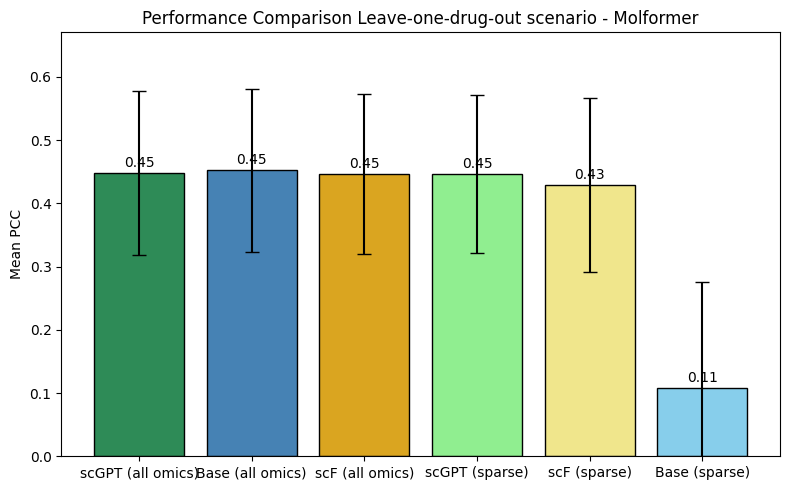

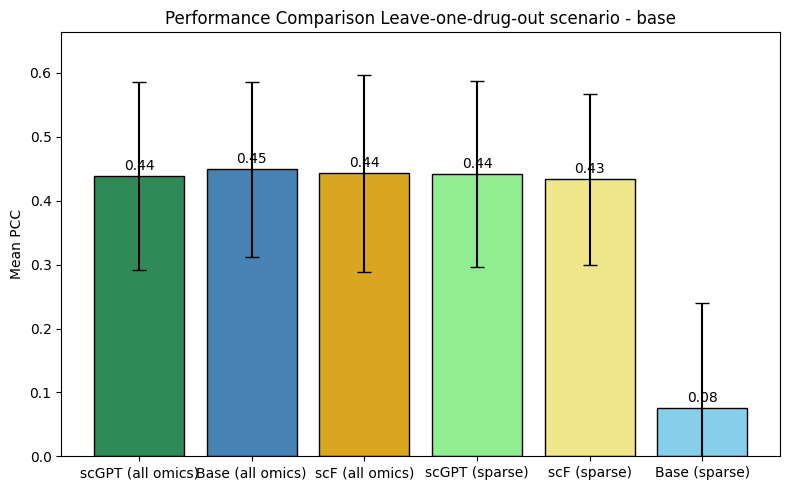

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def barplot_results(pccs_scgpt_with, pccs_base_with, pccs_scF_with, pccs, pccs_scFound, pccs_base, drugmodelname="base"):
    """
    Create a bar plot comparing the performance of different models.
    """
    
    mean_values = [
        np.mean(pccs_scgpt_with),  # scgpt with
        np.mean(pccs_base_with),   # base with
        np.mean(pccs_scF_with),   # base with
        np.mean(pccs),              # scGPT
        np.mean(pccs_scFound),     # scFound
        np.mean(pccs_base),        # base
    ]

    std_values = [
        np.std(pccs_scgpt_with),
        np.std(pccs_base_with),
        np.std(pccs_scF_with),
        np.std(pccs),
        np.std(pccs_scFound),
        np.std(pccs_base),
    ]

    labels = [
        'scGPT (all omics)',
        'Base (all omics)',
        'scF (all omics)',
        'scGPT (sparse)',
        'scF (sparse)',
        'Base (sparse)',
        ]

    colors = [
        'seagreen', 
        'steelblue', 
        'goldenrod',
        'lightgreen', 
        'khaki', 
        'skyblue',
        ]

    # Plot
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, mean_values, yerr=std_values, capsize=5, color=colors, edgecolor = "black")

    # Add values on top
    for bar, mean in zip(bars, mean_values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{mean:.2f}', ha='center', va='bottom')

    plt.ylabel('Mean PCC')
    plt.title('Performance Comparison Leave-one-drug-out scenario - ' + drugmodelname)
    plt.ylim(0, max(mean_values) + max(std_values) + 0.05)
    plt.tight_layout()
    plt.show()
barplot_results(pccs_scgpt_with_molf, pccs_base_with_molf, pccs_scfound_with_molf, pccs_molf, pccs_scFound_molf, pccs_base_molf, drugmodelname="Molformer")
barplot_results(pccs_scgpt_with, pccs_base_with, pccs_scfound_with, pccs, pccs_scFound, pccs_base, drugmodelname="base")

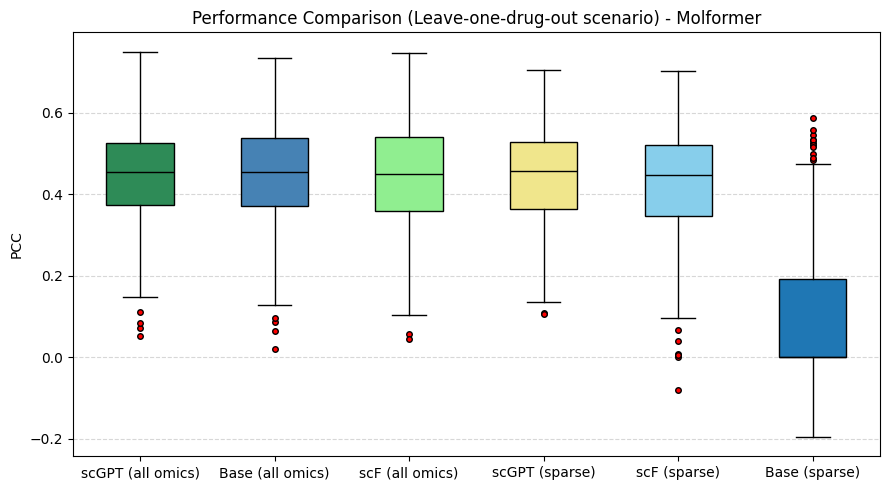

In [103]:
import numpy as np
import matplotlib.pyplot as plt

def boxplot_results(pccs_scgpt_with,pccs_base_with, pccs_scF_with, pccs, pccs_scFound, pccs_base, drugmodelname="base"):
    """
    Create a boxplot comparing the performance of different models.
    """
    # Your data
    data = [
        pccs_scgpt_with,   # scGPT (all omics)
        pccs_base_with,    # Base (all omics)
        pccs_scF_with,    # Base (all omics)
        pccs,              # scGPT (sparse)
        pccs_scFound,      # scF (sparse)
        pccs_base,         # Base (sparse)
    ]

    labels = [
        'scGPT (all omics)',
        'Base (all omics)',
        'scF (all omics)', 
        'scGPT (sparse)', 
        'scF (sparse)', 
        'Base (sparse)', 
        ]

    # Define distinct colors for each box
    colors = ['seagreen', 'steelblue', 'lightgreen', 'khaki', 'skyblue']

    # Create the boxplot
    fig, ax = plt.subplots(figsize=(9, 5))
    box = ax.boxplot(data, patch_artist=True, labels=labels,
                    medianprops=dict(color='black'),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black'),
                    flierprops=dict(marker='o', markersize=4, markerfacecolor='red'))

    # Apply different colors to each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Labels and formatting
    ax.set_ylabel('PCC')
    ax.set_title('Performance Comparison (Leave-one-drug-out scenario) - ' + drugmodelname)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# molformer
boxplot_results(pccs_scgpt_with_molf, pccs_base_with_molf, pccs_scfound_with_molf, pccs_molf, pccs_scFound_molf, pccs_base_molf, drugmodelname="Molformer")

# FUSED - Grid search results

In [104]:
grid_search_dir = "../data/eval/grid_search"
grid_search_files = os.listdir(grid_search_dir)
def get_grid_search_results(file):
    data = pd.read_csv(os.path.join(grid_search_dir, file))
    return data

for file in grid_search_files:
    if file.endswith('.csv'):
        results = get_grid_search_results(file)
        print(f"Results for {file}:")
        best_idx = np.argmax(results['pcc_val'])
        print("Best PCC:", np.max(results['pcc_val']))
        print("parameters:", 
              "embed_dim: ", results['embed_dim'][best_idx],
              "hidden_layer: ",results['hidden_layer'][best_idx], 
              "lr: ", results['lr'][best_idx],
              "attn: ", results['attn'][best_idx],
              "num_heads: ", results['num_heads'][best_idx])
        print(30 * "=")

Results for fusion_fusion_molformer_multi-omics_run_1.csv:
Best PCC: 0.9307781
parameters: embed_dim:  200 hidden_layer:  [100] lr:  0.0001 attn:  fusion num_heads:  10
Results for fusion_fusion_molformer_scFound_embeddings_multi-omics_run_1.csv:
Best PCC: 0.9297773
parameters: embed_dim:  200 hidden_layer:  [100] lr:  0.0001 attn:  fusion num_heads:  5
Results for fusion_fusion_molformer_scFound_embeddings_transcriptomics_run_1.csv:
Best PCC: 0.92972994
parameters: embed_dim:  200 hidden_layer:  [100] lr:  0.0001 attn:  fusion num_heads:  10
Results for fusion_fusion_molformer_scGPT_embeddings_multi-omics_run_1.csv:
Best PCC: 0.93050826
parameters: embed_dim:  200 hidden_layer:  [100] lr:  0.0001 attn:  fusion num_heads:  5
Results for fusion_fusion_molformer_scGPT_embeddings_transcriptomics_run_1.csv:
Best PCC: 0.93007064
parameters: embed_dim:  200 hidden_layer:  [100] lr:  0.0001 attn:  fusion num_heads:  10
Results for fusion_fusion_molformer_transcriptomics_run_1.csv:
Best PCC: 0

| **File**                                                                    | **Best PCC**  | **embed\_dim** | **hidden\_layer** | **lr** | **attn** | **num\_heads** |
| --------------------------------------------------------------------------- | ------------- | -------------- | ----------------- | ------ | -------- | -------------- |
| fusion\_fusion\_molformer\_multi-omics\_run\_1.csv                          | **0.9307781** | 200            | \[100]            | 0.0001 | fusion   | 10             |
| fusion\_fusion\_molformer\_scFound\_embeddings\_multi-omics\_run\_1.csv     | 0.9297773     | 200            | \[100]            | 0.0001 | fusion   | 5              |
| fusion\_fusion\_molformer\_scFound\_embeddings\_transcriptomics\_run\_1.csv | 0.9297299     | 200            | \[100]            | 0.0001 | fusion   | 10             |
| fusion\_fusion\_molformer\_scGPT\_embeddings\_multi-omics\_run\_1.csv       | 0.9305083     | 200            | \[100]            | 0.0001 | fusion   | 5              |
| fusion\_fusion\_molformer\_scGPT\_embeddings\_transcriptomics\_run\_1.csv   | 0.9300706     | 200            | \[100]            | 0.0001 | fusion   | 10             |
| fusion\_fusion\_molformer\_transcriptomics\_run\_1.csv                      | 0.9301734     | 200            | \[100]            | 0.0001 | fusion   | 2              |
| fusion\_mlp\_molformer\_multi-omics\_run\_1.csv                             | 0.9275318     | 200            | \[100, 50]        | 0.0001 | nan      | not used       |
| fusion\_mlp\_molformer\_scFound\_embeddings\_multi-omics\_run\_1.csv        | 0.9278923     | 200            | \[100, 50]        | 0.0001 | nan      | not used       |
| fusion\_mlp\_molformer\_scFound\_embeddings\_transcriptomics\_run\_1.csv    | 0.9279752     | 200            | \[100, 50]        | 0.0001 | nan      | not used       |
| fusion\_mlp\_molformer\_scGPT\_embeddings\_multi-omics\_run\_1.csv          | 0.9273045     | 200            | \[100, 50]        | 0.0001 | nan      | not used       |
| fusion\_mlp\_molformer\_scGPT\_embeddings\_transcriptomics\_run\_1.csv      | 0.9276835     | 200            | \[100, 50]        | 0.0001 | nan      | not used       |
| fusion\_mlp\_molformer\_transcriptomics\_run\_1.csv                         | 0.9279103     | 200            | \[100, 50]        | 0.0001 | nan      | not used       |
| fusion\_single\_molformer\_multi-omics\_run\_1.csv                          | 0.9202470     | 200            | \[100, 50]        | 0.0001 | single   | 2              |
| fusion\_single\_molformer\_scFound\_embeddings\_multi-omics\_run\_1.csv     | 0.9214118     | 200            | \[100, 50]        | 0.0001 | single   | 5              |
| fusion\_single\_molformer\_scFound\_embeddings\_transcriptomics\_run\_1.csv | 0.9228647     | 200            | \[100, 50]        | 0.0001 | single   | 2              |
| fusion\_single\_molformer\_scGPT\_embeddings\_multi-omics\_run\_1.csv       | 0.9215082     | 200            | \[100]            | 0.0001 | single   | 5              |
| fusion\_single\_molformer\_scGPT\_embeddings\_transcriptomics\_run\_1.csv   | 0.9211797     | 200            | \[100]            | 0.0001 | single   | 5              |
| fusion\_single\_molformer\_transcriptomics\_run\_1.csv                      | 0.9220867     | 200            | \[100, 50]        | 0.0001 | single   | 10             |


In [127]:
path = "../data/eval/pcc/"
file = "DeepCDR_with_mut_with_gexp_with_methy_256_256_256_bn_relu_GAP_scGPT_embeddings_run_1"
file2 = "DeepCDR_without_mut_with_gexp_without_methy_256_256_256_bn_relu_GAP_scGPT_embeddings_run_1"

read = np.load(os.path.join(path, file + ".npz"))
read1 = read["pubchem_id"]
read2 = np.load(os.path.join(path, file2 + ".npz"))["pubchem_id"]
print(read1)
print(read2)

['65110' '6710780' '6710780' ... '4261' '7251185' '11626927']
['65110' '6710780' '6710780' ... '4261' '7251185' '11626927']
